In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 # <h1 style='background:#6daa9f; border:0; color:black'><center>HEART FAILURE</center></h1> 
 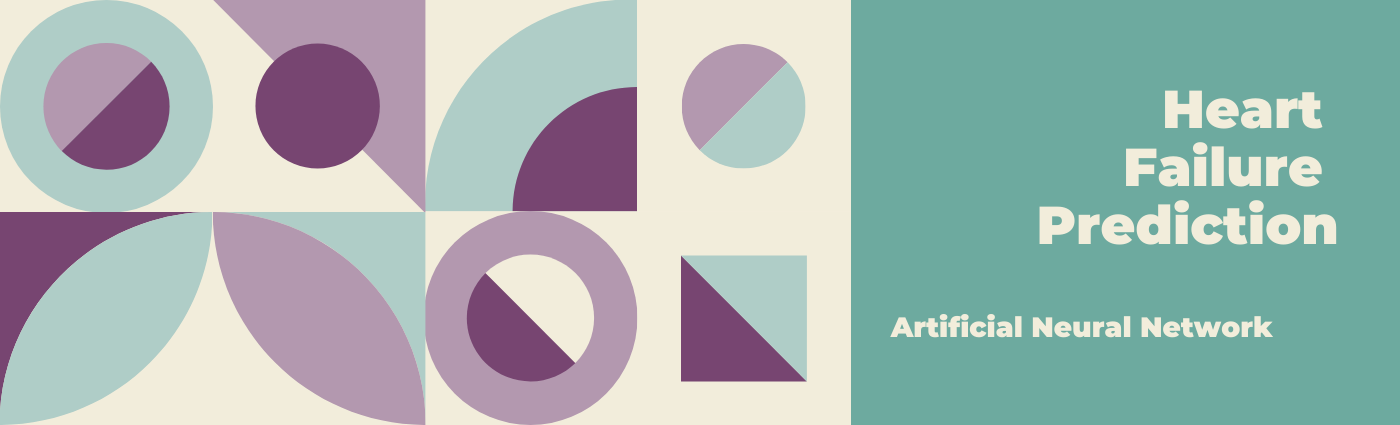

Cardiovascular diseases are the most common cause of deaths globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Heart failure is a common event caused by Cardiovascular diseases. It is characterized by the heart’s inability to pump an adequate supply of blood to the body. Without sufficient blood flow, all major body functions are disrupted. Heart failure is a condition or a collection of symptoms that weaken the heart. 


 # **<span style="color:#6daa9f;">TABLE OF CONTENTS</span>**
 

**IMPORTING LIBRARIES**

**LOADING DATA**

**DATA ANALYSIS**

**DATA PREPROCESSING**

**MODEL BUILDING**

**CONCLUSIONS**

# **<span style="color:#6daa9f;">IMPORTING LIBRARIES</span>**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# **<span style="color:#6daa9f;">LOADING DATA</span>**

In [ ]:
#loading data
data = pd.read_csv("../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")
data.head()

In [ ]:
data.info()

**About the data:**

* age: Age of the patient
* anaemia: If the patient had the haemoglobin below the normal range
* creatinine_phosphokinase: The level of the creatine phosphokinase in the blood in mcg/L
* diabetes: If the patient was diabetic
* ejection_fraction: Ejection fraction is a measurement of how much blood the left ventricle pumps out with each contraction
* high_blood_pressure: If the patient had hypertension
* platelets: Platelet count of blood in kiloplatelets/mL
* serum_creatinine: The level of serum creatinine in the blood in mg/dL
* serum_sodium: The level of serum sodium in the blood in mEq/L
* sex: The sex of the patient
* smoking: If the patient smokes actively or ever did in past
* time: It is the time of the patient's follow-up visit for the disease in months
* DEATH_EVENT: If the patient deceased during the follow-up period


# **<span style="color:#6daa9f;">DATA ANALYSIS</span>**

Steps in data analysis and visulisation:

We begin our analysis by plotting a count plot of the targer attribute. 
A corelation matrix od the various attributes to examine the feature importance.



In [ ]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["#6daa9f","#774571"]
sns.countplot(x= data["DEATH_EVENT"], palette= cols)

Point to note is that there is an imbalance in the data.

In [ ]:
#Examaning a corelation matrix of all the features 
cmap = sns.diverging_palette(275,150,  s=40, l=65, n=9)
corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True);

**Notable points:**
* Time of the patient's follow-up visit for the disease is crucial in as initial diagnosis with cardiovascular issue and treatment reduces the chances of any fatality. It holds and inverse relation. 
* Ejection fraction is the second most important feature. It is quite expected as it is basically the efficiency of the heart.
* Age of the patient is the third most correlated feature. Clearly as heart's functioning declines with ageing 

**Next, we will examine the count plot of age.**

In [ ]:
#Evauating age distrivution 
plt.figure(figsize=(20,12))
#colours =["#774571","#b398af","#f1f1f1" ,"#afcdc7", "#6daa9f"]
Days_of_week=sns.countplot(x=data['age'],data=data, hue ="DEATH_EVENT",palette = cols)
Days_of_week.set_title("Distribution Of Age", color="#774571")

In [ ]:
# Boxen and swarm plot of some non binary features.
feature = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium", "time"]
for i in feature:
    plt.figure(figsize=(8,8))
    sns.swarmplot(x=data["DEATH_EVENT"], y=data[i], color="black", alpha=0.5)
    sns.boxenplot(x=data["DEATH_EVENT"], y=data[i], palette=cols)
    plt.show()

I spotted outliers on our dataset. I didn't remove them yet as it may lead to overfitting. Though we may end up with better statistics. In this case, with medical data, the outliers may be an important deciding factor.

Next, we examine the kdeplot of time and age as they both are significant features.

In [ ]:
sns.kdeplot(x=data["time"], y=data["age"], hue =data["DEATH_EVENT"], palette=cols)

In [ ]:
data.describe().T

# **<span style="color:#6daa9f;">DATA PREPROCESSING</span>**

**Steps involved in Data Preprocessing** 
* Dropping the outliers based on data analysis
* Assigning values to features as X and target as y
* Perform the scaling of the features
* Split test and training sets

In [ ]:
#assigning values to features as X and target as y
X=data.drop(["DEATH_EVENT"],axis=1)
y=data["DEATH_EVENT"]

In [ ]:
#Set up a standard scaler for the features
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)   
X_df.describe().T

In [ ]:
#looking at the scaled features
colours =["#774571","#b398af","#f1f1f1" ,"#afcdc7", "#6daa9f"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_df,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#spliting test and training sets
X_train, X_test, y_train,y_test = train_test_split(X_df,y,test_size=0.25,random_state=7)

# **<span style="color:#6daa9f;">MODEL BUILDING</span>**

In this project, we build an artificial neural network.

**Following steps are involved in the model building**
* Initialising the ANN
* Defining by adding layers
* Compiling the ANN
* Train the ANN

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True)

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
from keras.optimizers import SGD
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 500,callbacks=[early_stopping], validation_split=0.2)

In [ ]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))

**Plotting training and validation loss over epochs**

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#6daa9f", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#774571", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

**Plotting training and validation accuracy over epochs**

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **<span style="color:#6daa9f;">CONCLUSIONS</span>**

**Concluding the model with:**

* Testing on the test set
* Evaluating the confusion matrix
* Evaluating the classification report

In [ ]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
np.set_printoptions()

In [ ]:
# confusion matrix
cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [ ]:
print(classification_report(y_test, y_pred))

**<span style="color:#b398af;"> If you liked this Notebook, please do upvote.</span>**

**<span style="color:#b398af;"> If you have any suggestions or questions, feel free to comment!</span>**

**<span style="color:#b398af;">Best Wishes!</span>**


# <h1 style='background:#6daa9f; border:0; color:black'><center>FIN</center></h1> 